# <center> Regularização de Modelos de Regressão
    
<center> <img src="https://www.kdnuggets.com/wp-content/uploads/hali-bias-variance-1.png" width=1300 align=center>
    

### Neste código, iremos revisar as técnicas de regularização em modelos de `regressão`

## 0. Carregamento de bibliotecas essenciais e dos dados

Vamos começar carregando bibliotecas importantes

In [1]:
# Carregando alguns módulos essenciais para trabalharmos os dados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
# Modelos
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
# Métricas
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

## 1. Dados e funçoes

### 1.1 Base de Dados

Para avaliar os efeitos de regularização, vamos construir um dataset fictício de uma única variável **x** e uma variável resposta **y**

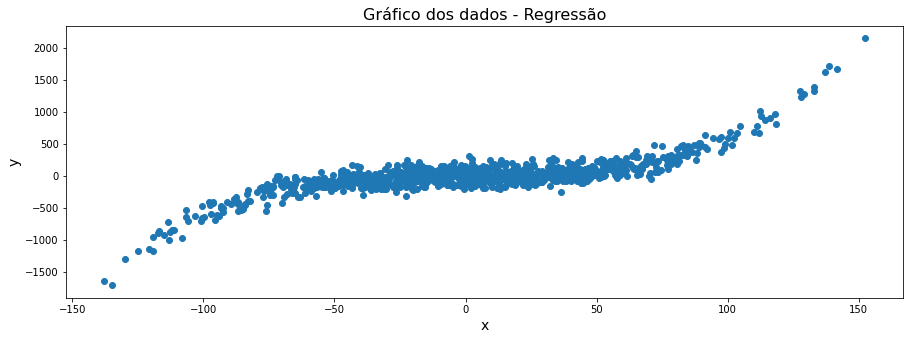

In [2]:
# Tamanho do dataset
tamanho = 1000
np.random.seed(0)

# Gerando dados
# X -> Função normal de média 0 e desvio padrão 100
dados_X = pd.Series(data=0 - 0.5 * np.random.normal(0, 100, tamanho))
# Y -> Função cúbica de X
dados_y = pd.Series(dados_X - 1.3 * (dados_X ** 2) + 0.6 * (dados_X ** 3) + np.random.normal(0,100000,tamanho))/1000
# Plot dos gráficos
plt.figure(figsize=(15,5))
plt.scatter(dados_X,dados_y)
plt.title('Gráfico dos dados - Regressão',size=16)
plt.xlabel('x',size=14)
plt.ylabel('y',size=14)
plt.show()

Também iremos construir um `DataFrame` com os dados, para facilitar os testes dos modelos

In [3]:
df = pd.concat([dados_X,dados_y],axis=1)
df.columns = ['x','y']
df = df.sort_values(by='x').reset_index(drop=True)
df.head()

,x,y
0,-137.967756,-1636.379653
1,-134.811203,-1709.608106
2,-129.721229,-1301.872202
3,-124.860020,-1174.153686
4,-120.622684,-1137.613771


Também vamos separar os modelos em treino e teste, reservando **20%** dos dados para o teste

In [4]:
# Separando em treino e teste
df_train = df.sample(frac=0.8).sort_index() # Amostra `frac` dos dados, sendo frac o percentual
df_test = df.loc[~df.index.isin(df_train.index)]

### 1.2 Funções de suporte

Para facilitar o processo de apresentar os resultados, iremos usar algumas funções de suporte

In [5]:
def plota_graficos(df_treino, df_teste, y_treino_pred, y_teste_pred):
    # Desenhando as curvas do modelo
    # Plot - Dados de treino
    plt.style.use('seaborn')
    fig, ax = plt.subplots(1,2, figsize=(20,5))
    ax[0].scatter(df_treino['x'],df_treino['y'],s=2,c='red')
    ax[0].plot(df_treino['x'],y_treino_pred, linewidth=1.2,c='blue')
    ax[0].legend(['Curva ajustada','Dados'],fontsize=12)
    ax[0].set_xlabel('X',size=12)
    ax[0].set_ylabel('y',size=12)
    ax[0].set_title('Performance - Dados de treino', size=14)
    # Plot - Dados de teste
    ax[1].scatter(df_teste['x'],df_teste['y'],s=2,c='red')
    ax[1].plot(df_teste['x'],y_teste_pred, linewidth=1.2,c='blue')
    ax[1].legend(['Curva ajustada','Dados'],fontsize=12)
    ax[1].set_xlabel('X',size=12)
    ax[1].set_ylabel('y',size=12)
    ax[1].set_title('Performance - Dados de teste', size=14)
    plt.show()
    return None

## 2. Testes de modelagem

### 2.0 Métrica de avaliação

Para todos os testes, iremos usar como métrica o `r2_score`, que é uma medida do percentual da variância total da variável resposta que pode ser explicada pelo modelo **além do que a média já explica**. Quanto maior, melhor! <p>
<img src = "https://miro.medium.com/max/1472/1*e1n9VlEFgaJWLKyaJQZwlw.png" width=1000> 

### 2.1 Média simples

Em um problema como esse, poderíamos tentar prever todos os resultados pela média simples dos resultados

In [48]:
# Avaliando a predição do modelo pela média
y_train_pred = np.ones_like(df_train.y)*df_train['y'].mean()
y_test_pred = np.ones_like(df_test.y)*df_test['y'].mean()
# Avaliando a métrica R2
r2_train = r2_score(df_train.y,y_train_pred)
r2_test = r2_score(df_test.y,y_test_pred)
print('R2 no conjunto de treino {:.3f}'.format(r2_train))
print('R2 no conjunto de teste {:.3f}'.format(r2_test))

R2 no conjunto de treino -0.000
R2 no conjunto de teste 0.000


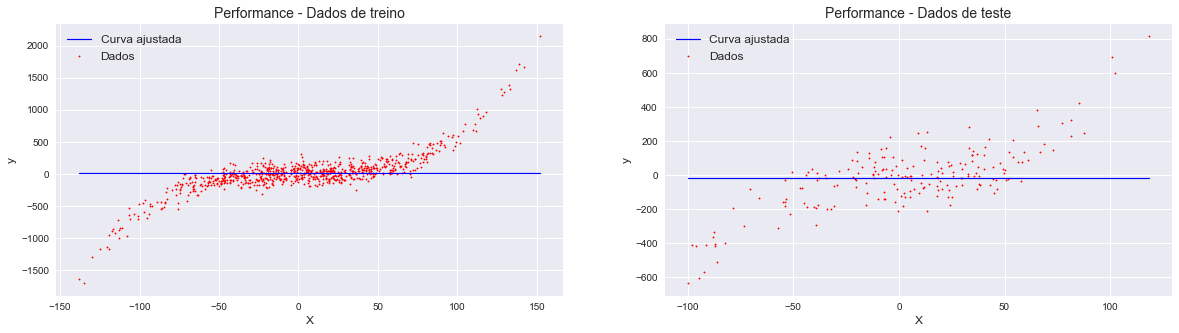

In [7]:
# Plot dos gráficos de performance - Treino e Teste
plota_graficos(df_train, df_test, y_train_pred, y_test_pred)

### 2.2 Modelos lineares

Evoluindo um pouco, podemos treinar uma **regressão linear** usando apenas a variável `x` como *feature*:

In [8]:
modelo = LinearRegression()
## o '[[]]' dobrado é necessário apenas porque o LinearRegression() exige um Dataframe para treino 
## e se fizéssemos 'df_train['x']' teriamos uma Series!
modelo.fit(df_train[['x']],df_train.y) 
# Avaliando a predição do modelo
y_train_pred = modelo.predict(df_train[['x']])
y_test_pred = modelo.predict(df_test[['x']])
# Avaliando a métrica R2
r2_train = r2_score(df_train.y,y_train_pred)
r2_test = r2_score(df_test.y,y_test_pred)
print('R2 no conjunto de treino {:.3f}'.format(r2_train))
print('R2 no conjunto de teste {:.3f}'.format(r2_test))

R2 no conjunto de treino 0.597
R2 no conjunto de teste 0.436


Já temos um resultado melhor do que a média! 

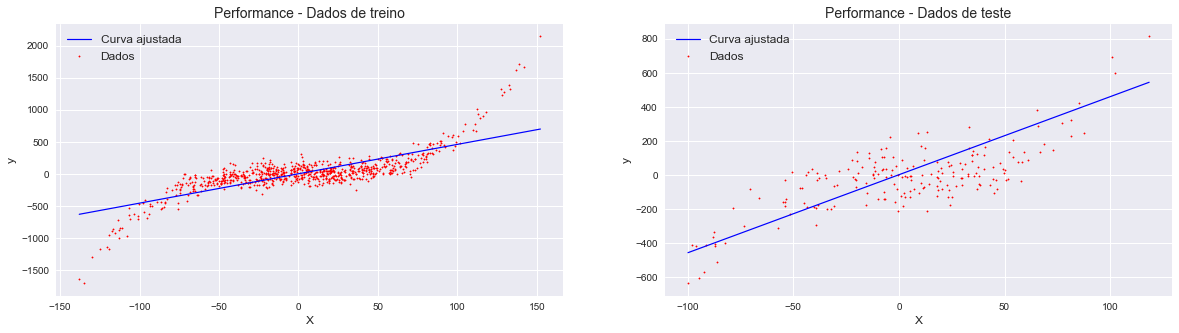

In [9]:
# Plot dos gráficos de performance - Treino e Teste
plota_graficos(df_train, df_test, y_train_pred, y_test_pred)

### 2.3 Modelos lineares com *feature engineering*

Para melhorar a performance do modelo, podemos criar features que são **potências** da variável original

In [51]:
# Copiando datasets para manter rastreamento dos resultados
df_train_feat = df_train.copy()
df_test_feat = df_test.copy()

In [52]:
# Começando com o quadrado da feature original x
df_train_feat['x2'] = df_train_feat['x']**2
df_test_feat['x2'] = df_test_feat['x']**2

In [12]:
modelo = LinearRegression()
modelo.fit(df_train_feat.drop('y',axis=1),df_train.y)
# Avaliando a predição do modelo
y_train_pred = modelo.predict(df_train_feat.drop('y',axis=1))
y_test_pred = modelo.predict(df_test_feat.drop('y',axis=1))
# Avaliando a métrica R2
r2_train = r2_score(df_train_feat.y,y_train_pred)
r2_test = r2_score(df_test_feat.y,y_test_pred)
print('R2 no conjunto de treino {:.3f}'.format(r2_train))
print('R2 no conjunto de teste {:.3f}'.format(r2_test))

R2 no conjunto de treino 0.600
R2 no conjunto de teste 0.444


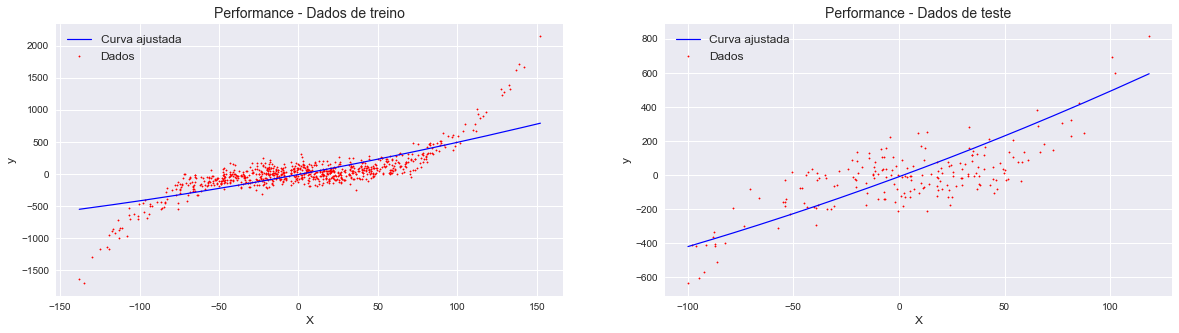

In [13]:
# Plot dos gráficos de performance - Treino e Teste
plota_graficos(df_train_feat, df_test_feat, y_train_pred, y_test_pred)

Podemos continuar criando variáveis com potencias de ordens maiores (variável ao cubo, quarta potência, etc..)

In [14]:
df_train_feat['x3'] = df_train_feat['x']**3
df_test_feat['x3'] = df_test_feat['x']**3
df_train_feat['x4'] = df_train_feat['x']**4
df_test_feat['x4'] = df_test_feat['x']**4
df_train_feat['x5'] = df_train_feat['x']**5
df_test_feat['x5'] = df_test_feat['x']**5

In [15]:
modelo = LinearRegression()
modelo.fit(df_train_feat.drop('y',axis=1),df_train.y)
# Avaliando a predição do modelo
y_train_pred = modelo.predict(df_train_feat.drop('y',axis=1))
y_test_pred = modelo.predict(df_test_feat.drop('y',axis=1))
# Avaliando a métrica R2
r2_train = r2_score(df_train_feat.y,y_train_pred)
r2_test = r2_score(df_test_feat.y,y_test_pred)
print('R2 no conjunto de treino {:.3f}'.format(r2_train))
print('R2 no conjunto de teste {:.3f}'.format(r2_test))

R2 no conjunto de treino 0.898
R2 no conjunto de teste 0.721


Continuamos tendo melhora na performance do modelo!

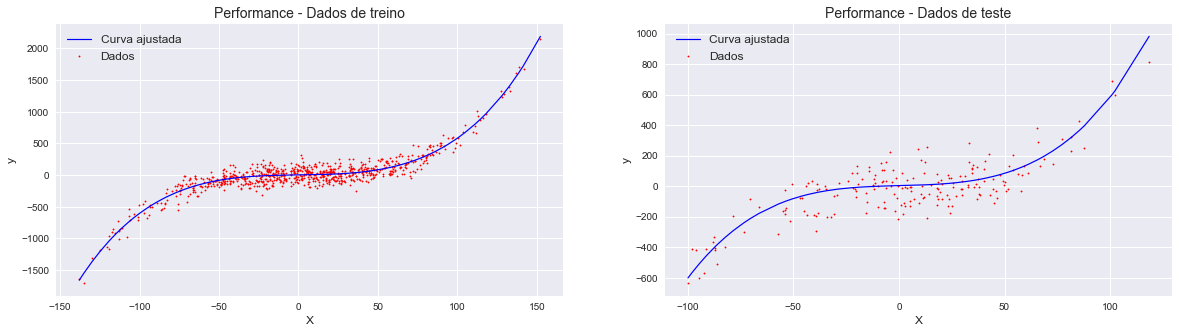

In [16]:
# Plot dos gráficos de performance - Treino e Teste
plota_graficos(df_train_feat, df_test_feat, y_train_pred, y_test_pred)

Vamos criar mais variáveis, até a oitava potência

In [17]:
df_train_feat['x6'] = df_train_feat['x']**6
df_test_feat['x6'] = df_test_feat['x']**6
df_train_feat['x7'] = df_train_feat['x']**7
df_test_feat['x7'] = df_test_feat['x']**7
df_train_feat['x8'] = df_train_feat['x']**8
df_test_feat['x8'] = df_test_feat['x']**8

In [18]:
modelo = LinearRegression()
modelo.fit(df_train_feat.drop('y',axis=1),df_train.y)
# Avaliando a predição do modelo
y_train_pred = modelo.predict(df_train_feat.drop('y',axis=1))
y_test_pred = modelo.predict(df_test_feat.drop('y',axis=1))
# Avaliando a métrica R2
r2_train = r2_score(df_train_feat.y,y_train_pred)
r2_test = r2_score(df_test_feat.y,y_test_pred)
print('R2 no conjunto de treino {:.3f}'.format(r2_train))
print('R2 no conjunto de teste {:.3f}'.format(r2_test))

R2 no conjunto de treino 0.899
R2 no conjunto de teste 0.722


A melhora na performance do modelo parece ter estabilizado

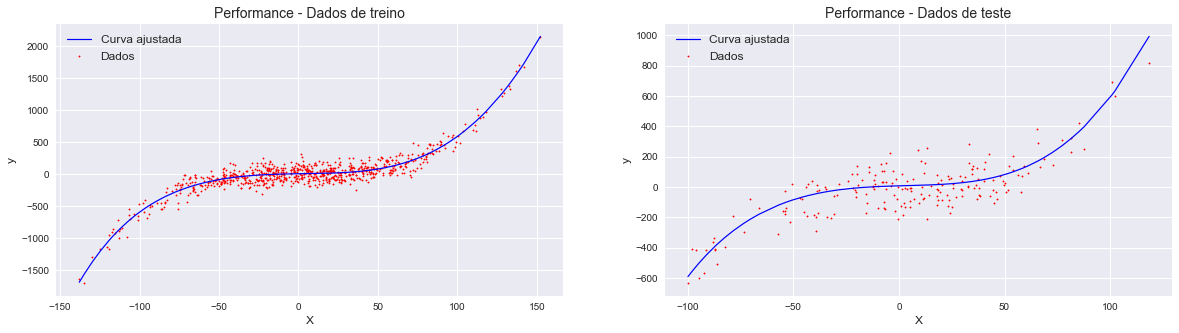

In [19]:
# Plot dos gráficos de performance - Treino e Teste
plota_graficos(df_train_feat, df_test_feat, y_train_pred, y_test_pred)

Vamos continuar até a 13ª potência!

In [20]:
df_train_feat['x9'] = df_train_feat['x']**9
df_test_feat['x9'] = df_test_feat['x']**9
df_train_feat['x10'] = df_train_feat['x']**10
df_test_feat['x10'] = df_test_feat['x']**10
df_train_feat['x11'] = df_train_feat['x']**11
df_test_feat['x11'] = df_test_feat['x']**11
df_train_feat['x12'] = df_train_feat['x']**12
df_test_feat['x12'] = df_test_feat['x']**12
df_train_feat['x13'] = df_train_feat['x']**13
df_test_feat['x13'] = df_test_feat['x']**13

In [21]:
modelo = LinearRegression()
modelo.fit(df_train_feat.drop('y',axis=1),df_train.y)
# Avaliando a predição do modelo
y_train_pred = modelo.predict(df_train_feat.drop('y',axis=1))
y_test_pred = modelo.predict(df_test_feat.drop('y',axis=1))
# Avaliando a métrica R2
r2_train = r2_score(df_train_feat.y,y_train_pred)
r2_test = r2_score(df_test_feat.y,y_test_pred)
print('R2 no conjunto de treino {:.3f}'.format(r2_train))
print('R2 no conjunto de teste {:.3f}'.format(r2_test))

R2 no conjunto de treino 0.884
R2 no conjunto de teste 0.690


Agora a performance do modelo parece ter começado a **piorar no conjunto de teste**

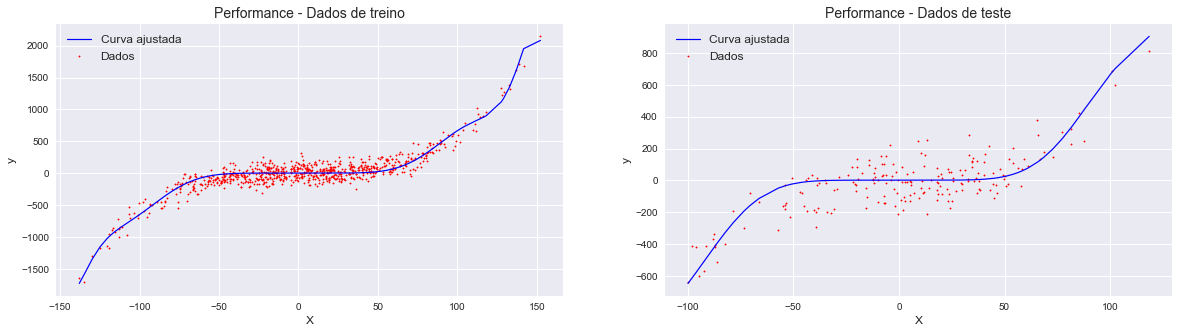

In [22]:
# Plot dos gráficos de performance - Treino e Teste
plota_graficos(df_train_feat, df_test_feat, y_train_pred, y_test_pred)

Vamos criar mais variáveis, até a décima oitava potência!!!

In [23]:
df_train_feat['x14'] = df_train_feat['x']**14
df_test_feat['x14'] = df_test_feat['x']**14
df_train_feat['x15'] = df_train_feat['x']**15
df_test_feat['x15'] = df_test_feat['x']**15
df_train_feat['x16'] = df_train_feat['x']**16
df_test_feat['x16'] = df_test_feat['x']**16
df_train_feat['x17'] = df_train_feat['x']**17
df_test_feat['x17'] = df_test_feat['x']**17
df_train_feat['x18'] = df_train_feat['x']**18
df_test_feat['x18'] = df_test_feat['x']**18

In [24]:
modelo = LinearRegression()
modelo.fit(df_train_feat.drop('y',axis=1),df_train.y)
# Avaliando a predição do modelo
y_train_pred = modelo.predict(df_train_feat.drop('y',axis=1))
y_test_pred = modelo.predict(df_test_feat.drop('y',axis=1))
# Avaliando a métrica R2
r2_train = r2_score(df_train_feat.y,y_train_pred)
r2_test = r2_score(df_test_feat.y,y_test_pred)
print('R2 no conjunto de treino {:.3f}'.format(r2_train))
print('R2 no conjunto de teste {:.3f}'.format(r2_test))

R2 no conjunto de treino 0.765
R2 no conjunto de teste 0.409


A performance piorou ainda mais a performance no conjunto de teste

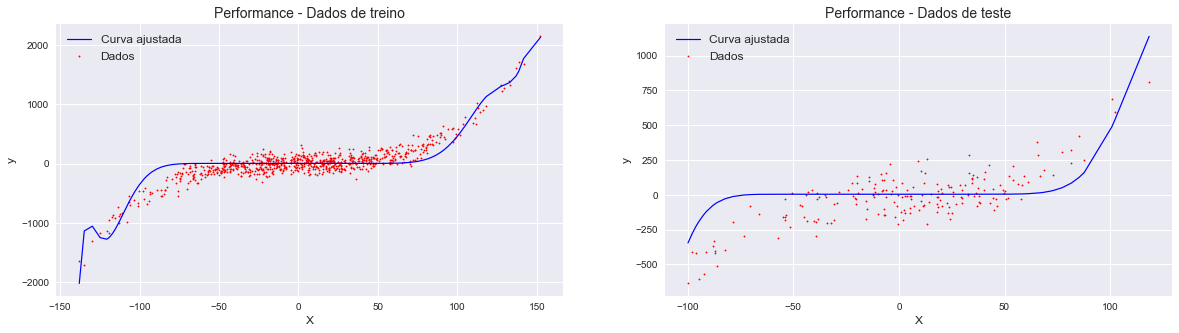

In [25]:
# Plot dos gráficos de performance - Treino e Teste
plota_graficos(df_train_feat, df_test_feat, y_train_pred, y_test_pred)

Como vimos, aumentar demais a **complexidade do modelo** pode resultar em um **baixo poder de generalização**, o que chamamos de **Overfitting**. 

Vamos avaliar agora como as performances de treino e teste variam conforme o grau do polinômio que incluímos no modelo

In [ ]:
def performance_polinomial(df_train, df_test, polinomio_max):
    # A partir dos dados, treina sucessivamente múltiplos modelos polinomiais e guarda as performances de treino e teste
    performances_treino = [] # Cria lista vazia para acumular os resultados no conjunto de treino
    performances_teste = [] # Mesmo processo, no conjunto de teste
    df_tr = df_train.copy() # Copia os dados, para evitar sobreescrever os dados originais
    df_te = df_test.copy()
    for i in range(2,polinomio_max+1): # Queremos a partir do 2º grau até o maior valor de polinônio, polinomio_max
        nome_var = 'x'+str(i)
        df_tr[nome_var] = df_tr['x']**i
        df_te[nome_var] = df_te['x']**i
        lr = LinearRegression().fit(df_tr.drop('y',axis=1),df_tr.y) # Treina uma regressão linear e ajusta aos dados criados
        performances_treino.append(r2_score(df_tr.y,lr.predict(df_tr.drop('y',axis=1)))) # Avalia a métrica e acumula ('append') na lista de treino
        performances_teste.append(r2_score(df_te.y,lr.predict(df_te.drop('y',axis=1)))) # Idem, para a lista de teste
    # Plot das performances
    plt.figure(figsize=(20,5))
    plt.plot(range(2,polinomio_max+1),performances_treino,c='r')
    plt.plot(range(2,polinomio_max+1),performances_teste,c='b')
    plt.title('Performances de treino e teste em modelos lineares',size=14)
    plt.legend(['Treino','Teste'],fontsize=14)
    plt.xlabel('Grau do polinômio', size=14)
    plt.ylabel('R2 Score (maior = melhor)', size=14)
    plt.show()
    return None                    

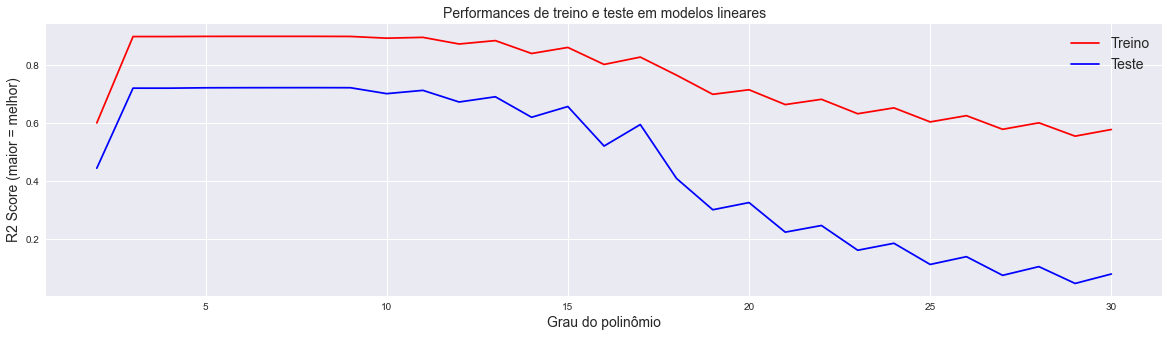

In [27]:
performance_polinomial(df_train, df_test, 30)

Parece que a partir do **grau 10**, a performance do teste começa a cair drasticamente

## 3. Regularização de modelos lineares - Resolvendo o problema

Quando a complexidade do modelo supera o que os dados podem nos fornecer, as regularizações podem nos ajudar a reduzir a **variabilidade** do modelo, ao preço de um pouco mais de **viés**. Apenas relembrando:

* `Viés`: Erro sistemático do modelo, ocorre quando as performances da métrica são ruins inclusive no conjunto de treino
* `Variabilidade`: Uma medida do quanto o modelo depende dos dados de treino para ser ajustado. Modelos com alta variabilidade mudam bruscamente se treinados usando outros conjuntos de dados, o que torna a previsão em novos dados muito mais instável e pior, perdendo **poder de generalização**

<center> <img src="https://staff.fnwi.uva.nl/r.vandenboomgaard/MachineLearning/_images/linregr_regularization.png" width=500 align=center>

### 3.1 A matemática das regularizações

Quando treinamos um modelo linear, no fundo estamos querendo descobrir os parâmetros (a.k.a. *pesos* das features) que minimizam a diferença entre os dados e a função encontrada. Matematicamente, seria:

<table><tr>
<td> <img src="https://i.stack.imgur.com/O752N.png" alt="Drawing" style="width: 700px;"/> </td>
<td> <img src="https://i.stack.imgur.com/zoYKG.png" alt="Drawing" style="width: 700px;"/> </td>
</tr></table>

Nas regressões `Ridge` e `LASSO`, a função custo é levemente alterada de forma que penaliza modelos com coeficientes **muito grandes**

<html>
<head>
<style>
table, th, td {
  border: 1px solid black;
  border-collapse: collapse;
}
th, td {
  padding: 5px;
}
th {
  text-align: left;
}
</style>
</head>
<body>

<table><tr>
<td> <img src="https://i.stack.imgur.com/O752N.png" alt="Drawing" style="width: 600px;"/> </td>
<td> <b><left>Ridge</left></b>: <img src="https://iq.opengenus.org/content/images/2019/03/equation2.png" alt="Drawing" style="width: 600px;"/> </td>
<td> <b><left>LASSO</left></b>: <img src="https://www.statisticshowto.com/wp-content/uploads/2015/09/lasso-regression.png" alt="Drawing" style="width: 600px;"/> </td>
</tr></table>

Em ambos os casos, quem controla a força dessa regularização é o parâmetro `lambda` (chamado de `alpha` nas funções do scikit):
* Quanto maior o parâmetro de regularização, maior a suavização da função final
* Quanto menor o parâmetro de regularização, mais próximo de uma regressão linear comum o modelo será

Vamos agora treinar nosso modelo com dados até a 18ª potência com uma regressão `Ridge`

In [54]:
from sklearn.linear_model import Ridge

In [28]:
modelo = Ridge()
modelo.fit(df_train_feat.drop('y',axis=1),df_train.y)
# Avaliando a predição do modelo
y_train_pred = modelo.predict(df_train_feat.drop('y',axis=1))
y_test_pred = modelo.predict(df_test_feat.drop('y',axis=1))
# Avaliando a métrica R2
r2_train = r2_score(df_train_feat.y,y_train_pred)
r2_test = r2_score(df_test_feat.y,y_test_pred)
print('R2 no conjunto de treino {:.3f}'.format(r2_train))
print('R2 no conjunto de teste {:.3f}'.format(r2_test))

R2 no conjunto de treino 0.900
R2 no conjunto de teste 0.719


O resultado voltou a ser bom!

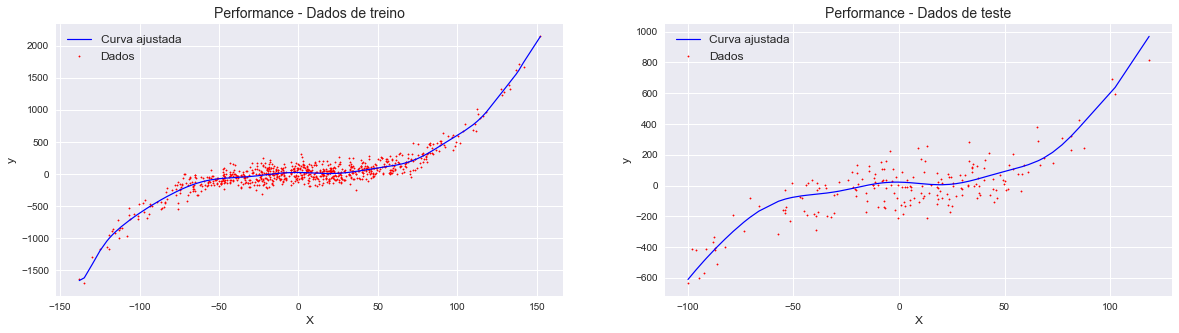

In [29]:
# Plot dos gráficos de performance - Treino e Teste
plota_graficos(df_train_feat, df_test_feat, y_train_pred, y_test_pred)

Vamos treinar um modelo agora aumentando o coeficiente de regularização

In [30]:
modelo = Ridge(alpha=1e50)
modelo.fit(df_train_feat.drop('y',axis=1),df_train.y)
# Avaliando a predição do modelo
y_train_pred = modelo.predict(df_train_feat.drop('y',axis=1))
y_test_pred = modelo.predict(df_test_feat.drop('y',axis=1))
# Avaliando a métrica R2
r2_train = r2_score(df_train_feat.y,y_train_pred)
r2_test = r2_score(df_test_feat.y,y_test_pred)
print('R2 no conjunto de treino {:.3f}'.format(r2_train))
print('R2 no conjunto de teste {:.3f}'.format(r2_test))

R2 no conjunto de treino 0.751
R2 no conjunto de teste 0.421


Parece que foi grande demais, pois a performance começou a piorar no conjunto de teste

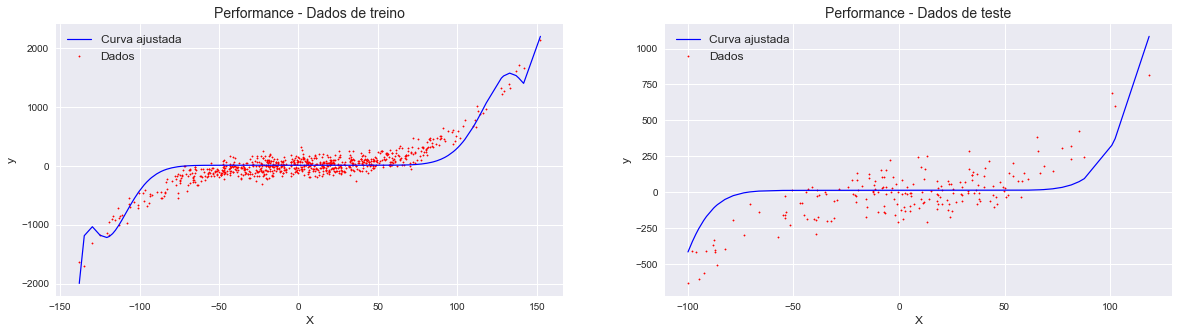

In [31]:
# Plot dos gráficos de performance - Treino e Teste
plota_graficos(df_train_feat, df_test_feat, y_train_pred, y_test_pred)

Vamos testar agora com um parâmetro de regularização bem maior

In [32]:
modelo = Ridge(alpha=1e80)
modelo.fit(df_train_feat.drop('y',axis=1),df_train.y)
# Avaliando a predição do modelo
y_train_pred = modelo.predict(df_train_feat.drop('y',axis=1))
y_test_pred = modelo.predict(df_test_feat.drop('y',axis=1))
# Avaliando a métrica R2
r2_train = r2_score(df_train_feat.y,y_train_pred)
r2_test = r2_score(df_test_feat.y,y_test_pred)
print('R2 no conjunto de treino {:.3f}'.format(r2_train))
print('R2 no conjunto de teste {:.3f}'.format(r2_test))

R2 no conjunto de treino 0.008
R2 no conjunto de teste -0.022


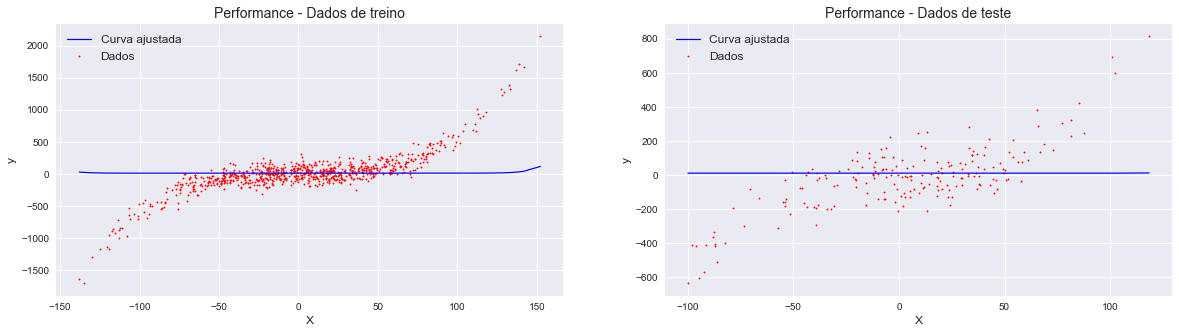

In [33]:
# Plot dos gráficos de performance - Treino e Teste
plota_graficos(df_train_feat, df_test_feat, y_train_pred, y_test_pred)

A regularização foi tão forte que a função final virou uma reta novamente (com um R2 similar à média que calculamos no início)

Para entender o que acontece com os coeficientes quando treinamos regressões `Ridge` e `LASSO`, fizemos essa função que treina iterativamente vários modelos variando o coeficiente de regularização

In [34]:
def comportamento_coefs_ridge(df_train, df_test,faixa_alphas):
    # Treina múltiplos modelos Ridge e plota o tamanho dos coeficientes proporcionalmente ao coeficiente da regressão linear pura
    coefs = []
    qtd_coefs = []
    df_tr = df_train.copy()
    df_te = df_test.copy()
    coefs_reg_lin = LinearRegression(normalize=True).fit(df_tr.drop('y',axis=1),df_tr.y).coef_
    for a in faixa_alphas:
        modelo = Ridge(alpha=a)
        modelo.fit(df_tr.drop('y',axis=1),df_tr.y)
        coefs.append(modelo.coef_)
        qtd_coefs.append((modelo.coef_>0).sum())
    # Plotando gráficos
    coefs_zip = list(zip(*coefs))
    fig, ax = plt.subplots(1,2, figsize=(20,5))
    for i in range(len(coefs_zip)):
        ax[0].plot(faixa_alphas,np.array(coefs_zip[i])/coefs_reg_lin[i])
        ax[0].legend(df_tr.drop('y',axis=1).columns,loc=4)
    ax[0].set_xlabel('Coeficiente de regularização (maior = mais regularização)',size=14)
    ax[0].set_ylabel('Coeficiente/Coeficiente da regressão linear',size=14)
    ax[0].set_xscale('log')
    ax[1].plot(faixa_alphas,qtd_coefs)
    ax[1].set_xscale('log')
    ax[1].set_xlabel('Coeficiente de regularização (maior = mais regularização)',size=14)
    ax[1].set_ylabel('Número de variáveis não nulas',size=16)
    ax[0].set_title('Valor dos coeficientes - regularização Ridge',size=14)
    ax[1].set_title('Sobrevivência de variáveis - regularização Ridge',size=14)
    plt.show()
    return None    

Vamos agora rodar a função

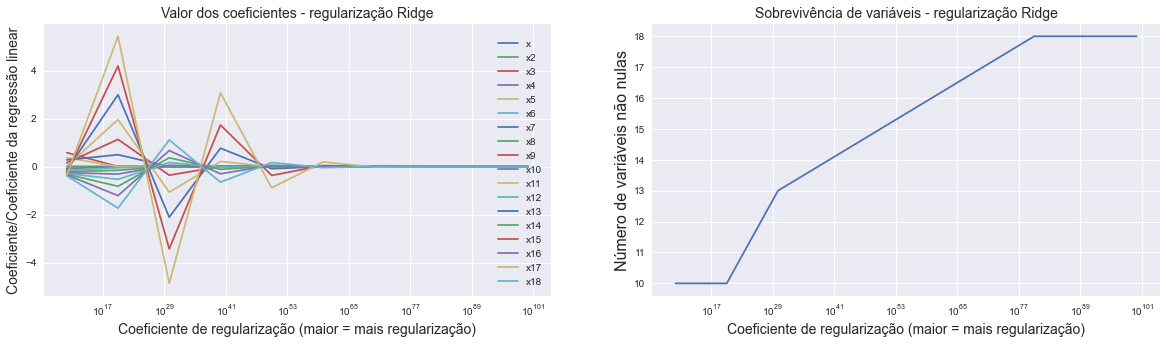

In [35]:
comportamento_coefs_ridge(df_train_feat, df_test_feat,[1e10,1e20,1e30,1e40,1e50,1e60,1e70,1e80,1e90,1e100])

Como podemos ver do gráfico da esquerda, os coeficientes começam a ficar **cada vez menores**, mas nunca zerados, de forma que o número de variáveis que "sobrevivem" no modelo nunca reduz

Vamos agora comparar com a função `LASSO`

In [36]:
def comportamento_coefs_lasso(df_train, df_test,faixa_alphas):
    # Treina múltiplos modelos Ridge e plota o tamanho dos coeficientes proporcionalmente ao coeficiente da regressão linear pura
    coefs = []
    qtd_coefs = []
    df_tr = df_train.copy()
    df_te = df_test.copy()
    coefs_reg_lin = LinearRegression(normalize=True).fit(df_tr.drop('y',axis=1),df_tr.y).coef_
    for a in faixa_alphas:
        modelo = Lasso(alpha=a)
        modelo.fit(df_tr.drop('y',axis=1),df_tr.y)
        coefs.append(modelo.coef_)
        qtd_coefs.append((modelo.coef_>0).sum())
    # Plotando gráficos
    coefs_zip = list(zip(*coefs))
    fig, ax = plt.subplots(1,2, figsize=(20,5))
    for i in range(len(coefs_zip)):
        ax[0].plot(faixa_alphas,np.array(coefs_zip[i])/coefs_reg_lin[i])
        ax[0].legend(df_tr.drop('y',axis=1).columns,loc=4)
    ax[0].set_xlabel('Coeficiente de regularização (maior = mais regularização)',size=14)
    ax[0].set_ylabel('Coeficiente/Coeficiente da regressão linear',size=14)
    ax[0].set_xscale('log')
    ax[1].plot(faixa_alphas,qtd_coefs)
    ax[1].set_xscale('log')
    ax[1].set_xlabel('Coeficiente de regularização (maior = mais regularização)',size=14)
    ax[1].set_ylabel('Número de variáveis não nulas',size=16)
    ax[0].set_title('Valor dos coeficientes - regularização LASSO',size=14)
    ax[1].set_title('Sobrevivência de variáveis - regularização LASSO',size=14)
    plt.show()
    return None    

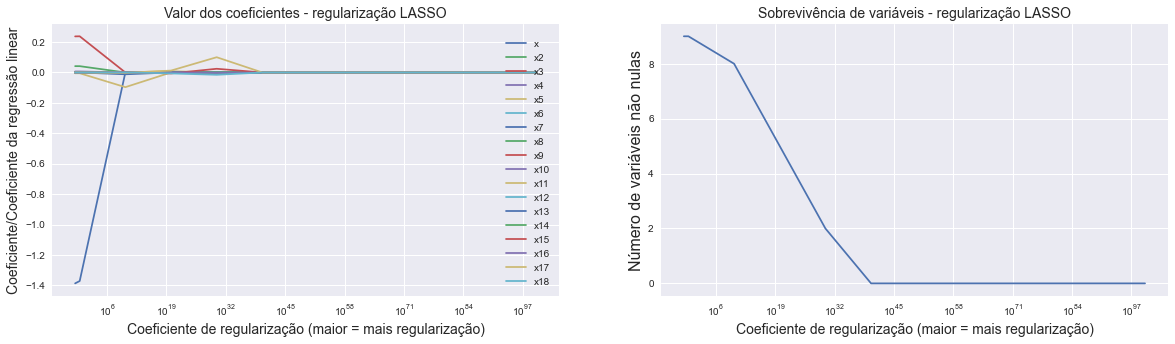

In [37]:
comportamento_coefs_lasso(df_train_feat, df_test_feat,[0.1,1,1e10,1e20,1e30,1e40,1e50,1e60,1e70,1e80,1e90,1e100])

Já na regularização `LASSO`, quanto maior for o coeficiente de regularização, mais variáveis tem seus coeficientes **zerados**, o que significa que essa regularização também faz um processo de **seleção de variáveis**

## 4. Selecionando variáveis sem perder qualidade

Agora que sabemos o poder de simplificar nosso modelo para não cometermos `Overfitting`, como realizar uma escolha eficiente de variáveis que faça esse trabalho?

In [38]:
# Terminando X e y de treino e teste
# Treino
X_train = df_train_feat.drop('y',axis=1)
y_train = df_train_feat.y
# Teste
X_test = df_test_feat.drop('y',axis=1)
y_test = df_test_feat.y

Vamos definir o objeto `SequentialFeatureSelector` que fará o trabalho de selecionar as variáveis para nós!

In [ ]:
# Descomente a linha abaixo e rode caso não tenha o mlxtend
#!pip intall mlxtend

In [39]:
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression

In [59]:
sfs = SequentialFeatureSelector(
    estimator=LinearRegression(), # Modelo que iremos fazer o processo iterativo
    forward=True, # `True` para Forward Selection, `False` para Backward Selection
    scoring='r2', # Escolha da métrica a ser acompanhada. Vamos usar o R2 aqui
    k_features = 4, # Número de features que queremos selecionar
    cv=2
)

# Ajustando o Feature Selector 
sfs.fit(X_train, y_train)

SequentialFeatureSelector(cv=2, estimator=LinearRegression(), k_features=4,
                          scoring='r2')

Ao ajustarmos o `Feature Selector`, podemos acessar os parâmetros finais, que serão as features selecionadas o resultado da métrica escolhida (neste caso, o `R2`)

In [60]:
# Features escolhidas 
sfs.k_feature_names_

('x3', 'x5', 'x7', 'x9')

In [58]:
# Métrica final obtida
sfs.k_score_

0.6677044668776366

Já que conseguimos usar o método, vamos construir uma função que construa o gráfico (crescente) do `R2` em função do número de variáveis escolhidas:

In [43]:
metricas_forward = []
# Número máximo de colunas
num_colunas = X_train.shape[1] # Segundo número do shape

for i in range(1,num_colunas+1):
    # Criando o seletor
    sfs = SequentialFeatureSelector(
        estimator=LinearRegression(), # Modelo que iremos fazer o processo iterativo
        forward=True, # `True` para Forward Selection, `False` para Backward Selection
        scoring='r2', # Escolha da métrica a ser acompanhada. Vamos usar o R2 aqui
        k_features = i, # Número de features que queremos selecionar
        cv=2 # Número de separações para validação
    )
    # Treinando o seletor
    sfs.fit(X_train,y_train)
    # Unindo a tupla (num_features, métrica) à lista `métricas`
    metricas_forward.append((i,sfs.k_score_))

In [44]:
metricas_backward = []
# Número máximo de colunas
num_colunas = X_train.shape[1] # Segundo número do shape

for i in range(1,num_colunas+1):
    # Criando o seletor
    sfs = SequentialFeatureSelector(
        estimator=LinearRegression(), # Modelo que iremos fazer o processo iterativo
        forward=False, # `True` para Forward Selection, `False` para Backward Selection
        scoring='r2', # Escolha da métrica a ser acompanhada. Vamos usar o R2 aqui
        k_features = i, # Número de features que queremos selecionar
        cv=2 # Número de separações para validação
    )
    # Treinando o seletor
    sfs.fit(X_train,y_train)
    # Unindo a tupla (num_features, métrica) à lista `métricas`
    metricas_backward.append((i,sfs.k_score_))

In [45]:
metricas_forward

[(1, 0.8710878491778999),
 (2, 0.8689906145163828),
 (3, 0.8669069459944663),
 (4, 0.8667559987617693),
 (5, 0.8668726333800788),
 (6, 0.8667744295279056),
 (7, 0.8407551357513188),
 (8, 0.8404732924654283),
 (9, 0.024905791230403485),
 (10, 0.018029696239728277),
 (11, -5.691873182942556),
 (12, -5.749559214637153),
 (13, -29.577799032340053),
 (14, -29.842086899286123),
 (15, -1042276.4470383258),
 (16, -9945841.175566232),
 (17, -675498514.7072829),
 (18, -75607077372.32552)]

In [46]:
metricas_backward

[(1, 0.8710878491778999),
 (2, 0.8634513136698756),
 (3, 0.8585301249035671),
 (4, 0.6677044668776366),
 (5, -3.79122646658634),
 (6, -5.676769725538989),
 (7, -5.676769725538989),
 (8, -5.67676972553898),
 (9, -5.676769725538972),
 (10, -5.676769725538974),
 (11, -5.676769725538994),
 (12, -8.784204034300554),
 (13, -8.784204034310005),
 (14, -183107.05621670032),
 (15, -3278415.500725795),
 (16, -3278415.885611569),
 (17, -675498514.7072829),
 (18, 0)]

Tanto na `forward` quanto na `backward` selection, temos algumas conclusões importantes:
* Quanto mais variáveis usadas, mais Overfitting temos!
* O menor número ótimo de features parece ser de  `3` features, número esse que encontramos no `backward selection`

## 4. Conclusões!

Regularização é sempre uma boa alternativa para evitar que o nosso modelo **decore** os dados de treino e, portanto, generalize bem para dados novos.

Vimos que há diferentes formas de fazer isso dependendo do modelo treinado, e vamos revisar rapidamente!:
* **Modelos lineares** podem ser regularizados usando `Ridge` ou `LASSO`, sendo que em ambos os casos quanto maior o coeficiente de regularização (`alpha`), maior a força da regularização, porém se o coeficiente for muito grande o modelo será simples demais, causando **Underfitting**
* **Para uma abordagem mais genérica**, podemos usar o `forward feature selection` ou o `backward feature selection` para encontrar o ponto ótimo de seleção de features, evitando Overfitting no próprio processo.

Tentem usar outros modelos e testem os parâmetros para identificar cenários de Overfitting e Underfitting!

# <center> Muito obrigado a todos!!!
    
<center> <img src="https://s.studiobinder.com/wp-content/uploads/2020/07/Michael-Scott-Wayne-Gretzsky-Quotes.jpg?resolution=1680,0.75" width=1500>